In [4]:
import sys
sys.path.append('../lib')
from tablenet import TableNet
from table_detection import Pipeline, TableMask, ColumnMaskProcessor, LineMaskProcessor, Signal
from utils import *
import cv2
from shutil import copyfile
import os
import numpy as np
import imutils
import tqdm
import json
from utils import *
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

from collections import namedtuple
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')
%matplotlib inline

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
model = TableNet.build()
latest = tf.train.latest_checkpoint('models/2020_09_23')
model.load_weights(latest)

In [7]:
images = [os.path.join('../data/ocr/',file) for file in os.listdir('../data/ocr/') if file.split('.')[-1]=='jpg']

In [8]:
image = plt.imread(os.path.join('../data/ocr/',"8413671001757.nutrition.jpg"))

In [1]:
pipeline = Pipeline(model,image)
pipeline.run(0.8)

NameError: name 'Pipeline' is not defined

In [10]:
column_mask_processor = ColumnMaskProcessor(pipeline.images[0].shape,pipeline.predicted_column_masks[0].numpy().reshape(256,256).astype('uint8'))
column_mask_processor.process_mask()
column_mask_processor.get_peaks(20,25)
column_mask_processor.find_column_areas()

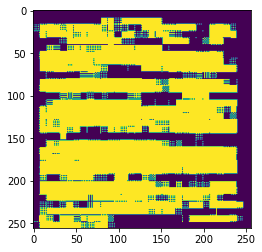

In [11]:
plt.imshow(pipeline.predicted_line_mask)

In [100]:
#rotated = cv2.rotate(pipeline.images[-1].numpy().copy(),cv2.ROTATE_90_COUNTERCLOCKWISE)
#pipeline = Pipeline(model,tf.convert_to_tensor(rotated))
#pipeline.run(0.8,loop_until_converge=False)
line_mask_processor = LineMaskProcessor(pipeline.images[0].shape,pipeline.predicted_line_mask.reshape(256,256).astype('uint8'))
line_mask_processor.process_mask()
line_mask_processor.get_peaks(15,5)
line_mask_processor.find_column_areas()

(256, 256)


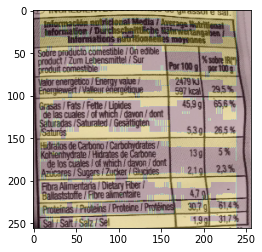

In [103]:
plt.imshow(cv2.resize(image.copy(),(256,256)))
plt.imshow(line_mask_processor.processed_column_mask,alpha=0.2)

In [104]:
import itertools

lines = line_mask_processor.peaks.copy()
lines.insert(0,0)
lines.append(image.shape[0])

columns = column_mask_processor.peaks.copy()
columns.insert(0,0)
columns.append(image.shape[1])

points = np.array(list(itertools.product(columns,lines)))
points = points.reshape(len(columns),len(lines),2)
img = image.copy()

In [110]:
table = []
for i in range(1,len(columns)):
    line = []
    for j in range(1,len(lines)):
        point1 = points[i-1][j-1]
        point2 = points[i][j]
        line.append(Rectangle(point1[0],point1[1],point2[0],point2[1]))
    table.append(line)

In [111]:
shape=image.shape

In [112]:
img = image.copy()

In [113]:
for line in table:
    for cell in line:
        cv2.rectangle(img,(cell.xmin,cell.ymin),(cell.xmax,cell.ymax),color=(255,0,0),thickness=5)

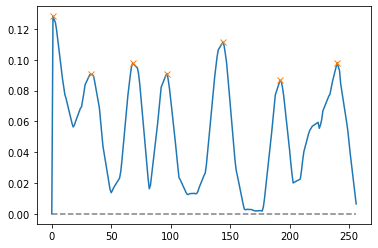

In [114]:
plt.plot(line_mask_processor.signal)
plt.plot(line_mask_processor.signal_peaks, line_mask_processor.signal[line_mask_processor.signal_peaks], "x")
plt.plot(np.zeros_like(line_mask_processor.signal), "--", color="gray")

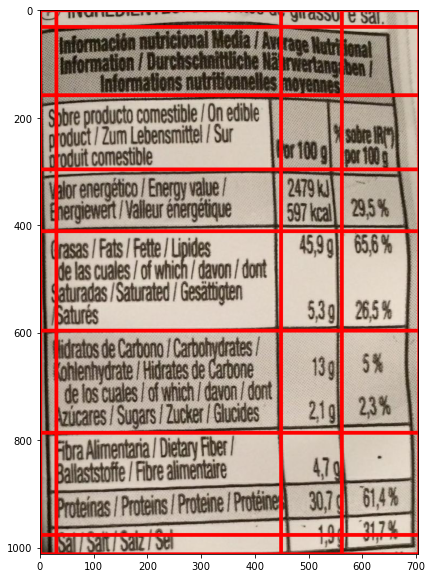

In [115]:
plt.figure(figsize=(20,10))
plt.imshow(img)

In [116]:
with open(os.path.join('../data/ocr/',"8413671001757.nutrition.json")) as file:
    bounding_boxes = json.load(file)['words']

In [117]:
def circumscribed_rectangle(bounding_box):
    '''
    get circumscribed rectangle for this kind of bounding box
     ----------------
    |1-------------2|
    | \            || 
    |   4----------3|
    -----------------
    '''
    pt1 = bounding_box[0]
    pt2 = bounding_box[1]
    pt3 = bounding_box[2]
    pt4 = bounding_box[3]
    x1 = min(pt1['x'],pt4['x'])
    y1 = min(pt1['y'],pt2['y'])
    x2 = max(pt2['x'],pt3['x'])
    y2 = max(pt3['y'],pt4['y'])
    return Rectangle(x1,y1,x2,y2)

def area(rect):
    l = rect.xmax-rect.xmin
    h = rect.ymax-rect.ymin
    return l*h

def intersection_area(rect1,rect2):
    dx = min(rect1.xmax, rect2.xmax) - max(rect1.xmin, rect2.xmin)
    dy = min(rect1.ymax, rect2.ymax) - max(rect1.ymin, rect2.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    else:
        return 0

In [137]:
col = table[3]
col_x_min = col[0].xmin
col_x_max = col[0].xmax
column_rect = Rectangle(col_x_min,0,col_x_max,shape[1])

In [138]:
column_rect

Rectangle(xmin=561, ymin=0, xmax=705, ymax=705)

In [141]:
bounding_boxes[-5]['bounding_box']

[{'x': 482, 'y': 727},
 {'x': 547, 'y': 720},
 {'x': 552, 'y': 767},
 {'x': 487, 'y': 774}]

In [140]:
circumscribed_rectangle(bounding_boxes[-5]['bounding_box'])

Rectangle(xmin=482, ymin=720, xmax=552, ymax=774)

In [139]:
intersection_area(column_rect,circumscribed_rectangle(bounding_boxes[-5]['bounding_box']))

0

In [142]:
words = bounding_boxes.copy()
shape = pipeline.images[-1].shape
table_shape = (np.array(table).shape[0],np.array(table).shape[1])
extracted_table = np.empty(shape=table_shape+(0,)).tolist()
for i, bounding_box in tqdm.tqdm(enumerate(bounding_boxes)):
    try:
        done=False
        word_rect = circumscribed_rectangle(bounding_box['bounding_box'])
        word_area = area(word_rect)
        for col_num,col in enumerate(table):
            col_x_min = col[0].xmin
            col_x_max = col[0].xmax
            column_rect = Rectangle(col_x_min,0,col_x_max,shape[0])
            inclusion_score = intersection_area(column_rect,word_rect)/word_area
            print('{} included in col {} with score of {}'.format(bounding_boxes[i]['text'],col_num,inclusion_score))
            if inclusion_score>0.5:
                for line_num,cell in enumerate(col):
                    inclusion_score = intersection_area(cell,word_rect)/word_area
                    if inclusion_score>0.5:
                        #bounding_boxes[i]['cell']= (line_num,col_num)
                        extracted_table[col_num][line_num].append(bounding_boxes[i]['text'])
                        done=True
                        break
                if done:
                    break
        if col_num == len(table)-1 and line_num == len(col)-1:
            print(bounding_boxes[i]['text'])
                    
    except KeyboardInterrupt:
        print("Interrupted")
        break
    except:
        words.remove(bounding_box)

105it [00:00, 1504.16it/s]

Información included in col 0 with score of 0.03164556962025317
Información included in col 1 with score of 0.9683544303797469
nutricional included in col 0 with score of 0.0
nutricional included in col 1 with score of 1.0
Media included in col 0 with score of 0.0
Media included in col 1 with score of 1.0
/ included in col 0 with score of 0.0
/ included in col 1 with score of 1.0
Average included in col 0 with score of 0.0
Average included in col 1 with score of 0.3855421686746988
Average included in col 2 with score of 0.6144578313253012
Nutritional included in col 0 with score of 0.0
Nutritional included in col 1 with score of 0.0
Nutritional included in col 2 with score of 0.5172413793103449
Information/Durchschnittliche included in col 0 with score of 0.0
Information/Durchschnittliche included in col 1 with score of 1.0
Nährwertangaben/ included in col 0 with score of 0.0
Nährwertangaben/ included in col 1 with score of 0.17535545023696683
Nährwertangaben/ included in col 2 with sc

In [143]:
table_result = pd.DataFrame(extracted_table).applymap(lambda x: ' '.join(x)).T.replace('',np.nan).dropna(how='all').dropna(axis=1,how='all')

In [144]:
pd.DataFrame(extracted_table).applymap(lambda x: ' '.join(x)).T

,0,1,2,3
0,,,,
1,,Información nutricional Media / Information/Durchschnittliche Informations nutritionnelles,Average Nutritional Nährwertangaben/ moyennes,
2,,Sobre producto comestible / On edible product/Zum Lebensmittel /Sur produit comestible,% Por 100 g,sobre IR por 100 g
3,,Valor energético /Energy value Energiewert/Valleur énérgétique,2479 kJ 597 kcal,"29,5 %"
4,,Grasas /Fats/Fette /Lipides de las cuales/of which /davon / dont Saturadas/Saturated/Gesätigten Saturés,"45,9 g 5,39","65,6% 26,5 %"
5,,Hidratos de Carbono / Carbohydrates/ Kohlenhydrate / Hidrates de Carbone de los cuales / of which /davon/dont Azúcares/Sugars/ Zucker/ Glucides,13 g 21g,"5% 2,3%"
6,,Fibra Alimentaria/Dietary Fiber/ Ballaststoffe/Fibre alimentaire Proteinas/Proteins /Proteine / Protéines,"30,7 g 4,7g","61,4% 31,7%"
7,,Sal/Salt/Salz/Sel,"1,9g",


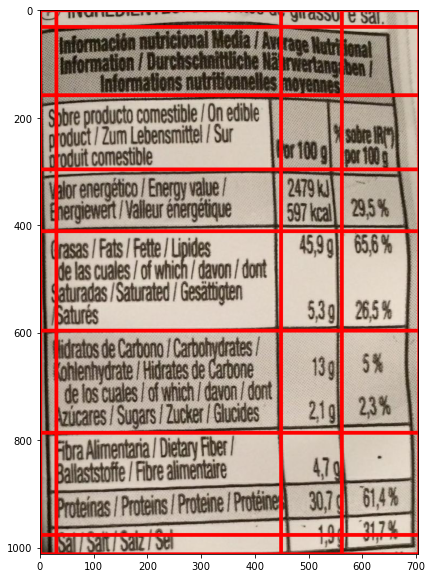

In [145]:
plt.figure(figsize=(20,10))
plt.imshow(img)

In [146]:
table_result

,1,2,3
1,Información nutricional Media / Information/Durchschnittliche Informations nutritionnelles,Average Nutritional Nährwertangaben/ moyennes,NaN
2,Sobre producto comestible / On edible product/Zum Lebensmittel /Sur produit comestible,% Por 100 g,sobre IR por 100 g
3,Valor energético /Energy value Energiewert/Valleur énérgétique,2479 kJ 597 kcal,"29,5 %"
4,Grasas /Fats/Fette /Lipides de las cuales/of which /davon / dont Saturadas/Saturated/Gesätigten Saturés,"45,9 g 5,39","65,6% 26,5 %"
5,Hidratos de Carbono / Carbohydrates/ Kohlenhydrate / Hidrates de Carbone de los cuales / of which /davon/dont Azúcares/Sugars/ Zucker/ Glucides,13 g 21g,"5% 2,3%"
6,Fibra Alimentaria/Dietary Fiber/ Ballaststoffe/Fibre alimentaire Proteinas/Proteins /Proteine / Protéines,"30,7 g 4,7g","61,4% 31,7%"
7,Sal/Salt/Salz/Sel,"1,9g",NaN


In [60]:
stop_words = "% g kcal kJ /".split()

In [ ]:
pd.applymap(lambda x: ' '.join(x))